## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


In [ ]:
# pip install odc-geo --quiet

In [ ]:
# pip install git+https://github.com/digitalearthafrica/deafrica-coastlines.git --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
import odc.geo.xr
from odc.algo import xr_geomedian

from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides
from intertidal.elevation import load_data, pixel_tide_sort, ds_to_flat, create_dask_gateway_cluster, abslmp_correction
from intertidal.utils import load_config

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42801,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:42113,Total threads: 31
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/33621/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:45529,


## Setup

In [3]:
dc = datacube.Datacube(app='HLTC')

In [4]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4)

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Load data

In [5]:
ds = load_data(dc=dc, 
               geom=geom, 
               time_range=('2019', '2021'), 
               resolution=10, 
               s2_prod="s2_nbart_norm",
               ls_prod=None)
ds

<xarray.Dataset>
Dimensions:      (time: 199, y: 1495, x: 1752)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-04T02:12:36.899000 ... 2021-12...
  * y            (y) float64 7.948e+06 7.948e+06 ... 7.933e+06 7.933e+06
  * x            (x) float64 -8.692e+05 -8.692e+05 ... -8.517e+05 -8.517e+05
    spatial_ref  int32 32753
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

## Pixel-based tides

In [6]:
# Model tides into every pixel in the three-dimensional (x by y by time) satellite dataset
ds["tide_m"], _ = pixel_tides(ds, resample=True)



Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 199/199 [00:03<00:00, 50.66it/s]


## HLTC

In [7]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42801,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:42113,Total threads: 31
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/33621/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:45529,


In [8]:
ds.persist()

<xarray.Dataset>
Dimensions:      (time: 199, y: 1495, x: 1752)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-04T02:12:36.899000 ... 2021-12...
  * y            (y) float64 7.948e+06 7.948e+06 ... 7.933e+06 7.933e+06
  * x            (x) float64 -8.692e+05 -8.692e+05 ... -8.517e+05 -8.517e+05
    spatial_ref  int32 32753
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    tide_m       (time, y, x) float32 2.01 2.01 2.01 2.01 ... -1.03 -1.03 -1.03
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

In [9]:
# Calculate max, min and full range of tide
tide_max = ds.tide_m.max(dim='time')
tide_min = ds.tide_m.min(dim='time')
tide_range = tide_max - tide_min

In [10]:
# Calculate a threshold for low tide composite
min_thresh = tide_min + (tide_range * 0.2)
ds_min = ds.where(ds.tide_m <= min_thresh)

# Drop fully cloudy scenes to speed up geomedian
ds_min = ds_min.sel(time = ds_min.tide_m.isnull().mean(dim=['x', 'y']) < 1).drop('tide_m')
ds_min

<xarray.Dataset>
Dimensions:      (time: 35, y: 1495, x: 1752)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-29T02:12:28.179000 ... 2021-09...
  * y            (y) float64 7.948e+06 7.948e+06 ... 7.933e+06 7.933e+06
  * x            (x) float64 -8.692e+05 -8.692e+05 ... -8.517e+05 -8.517e+05
    spatial_ref  int32 32753
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(1, 1495, 1752), meta=np.ndarray>
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

In [11]:
# Compute geomedian
ds_min_median = xr_geomedian(ds=ds_min)
ds_min_median.load()

<xarray.Dataset>
Dimensions:  (y: 1495, x: 1752)
Coordinates:
  * y        (y) float64 7.948e+06 7.948e+06 7.948e+06 ... 7.933e+06 7.933e+06
  * x        (x) float64 -8.692e+05 -8.692e+05 ... -8.517e+05 -8.517e+05
Data variables:
    blue     (y, x) float32 0.1375 0.1386 0.1385 ... 0.04671 0.04395 0.04049
    green    (y, x) float32 0.1193 0.1201 0.1206 ... 0.0666 0.0624 0.05529
    red      (y, x) float32 0.03568 0.03598 0.03638 ... 0.08204 0.07588 0.06782
    nir      (y, x) float32 0.01881 0.01932 0.01914 ... 0.1744 0.1667 0.1577
    swir1    (y, x) float32 0.01622 0.0161 0.01592 ... 0.2306 0.226 0.2234
    swir2    (y, x) float32 0.01622 0.0161 0.01592 ... 0.2306 0.226 0.2234

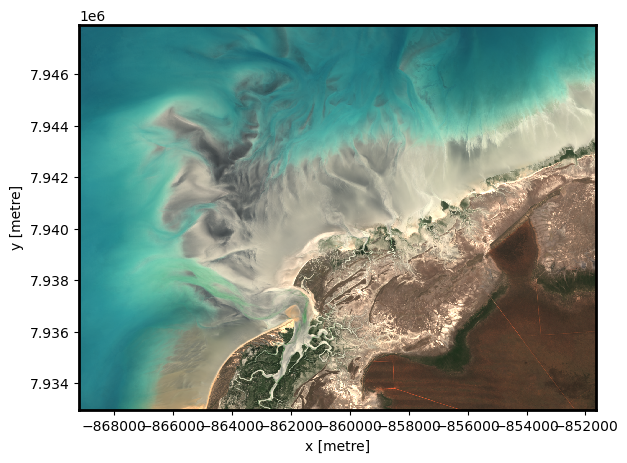

In [12]:
ds_min_median.odc.to_rgba(vmin=0.0, vmax=0.3).plot.imshow(size=5)

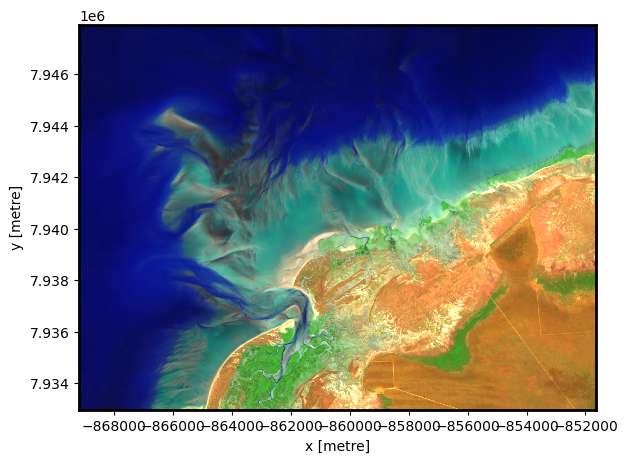

In [13]:
ds_min_median.odc.to_rgba(bands=['swir1', 'nir', 'green'], vmin=0, vmax=0.4).plot.imshow(size=5)

In [14]:
ds_min_median.to_array().odc.write_cog('hltc_20_s2.tif', overwrite=True)

PosixPath('hltc_20_s2.tif')

In [15]:
client.shutdown()

/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
